# 0. Import Data and Define Functions

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier

from tabulate import tabulate
import json
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv("marketing_training.csv")
df_test = pd.read_csv("marketing_test.csv")
print('training data shape:', df_train.shape)
print('testing data shape:', df_test.shape)

training data shape: (7414, 22)
testing data shape: (824, 22)


In [3]:
# define a function to replace the categorical variable with dummy variables (one-hot encoding)
# e.g column 'gender' = female --> column 'female' = 1 
def Category2Dummy(df, feature):
    dummy = pd.get_dummies(df[feature])
    dummy.columns = [feature + '_' +str(x) for x in dummy.columns]
    dummy.drop(dummy.columns[len(dummy.columns)-1], axis=1, inplace=True)
    df = pd.concat([df, dummy], axis=1)
    return df

def Category2Numeric(x, Map):
    if x in Map:
        return Map[x]
    
def Numeric2Category(x,Map):
    for i, item in Map.items():
        if x==item:
            return(i)

# impute the missing values: (dataframe, model, columns for imputation, target column with missing values)
def Impute(df, model, column, target):
    for i, row in df[df[target].isnull()].iterrows():
        df.ix[i, target] = model.predict(row[column].reshape(1, -1))
    return df

# 1. Data Preprocessing
###    *Missing Value Imputation
###    *Categorical into Dummy Variables
###    *Handle the imbalance Problem

In [4]:
df_train.isnull().sum() # missing values: 'custAge','profession','marital'

custAge           1804
profession           0
marital              0
schooling         2155
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week        711
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
pmonths              0
pastEmail            0
responded            0
dtype: int64

##### Typically three ways to deal with missing value. Here I implemented the first method, since it can better capture the correlation between variables.
    1.Imputation with prediction method (tree-based method, KNN, Logistic Regression, etc.)
    2.Imputation with mean/mode 
    3.Removing the missing rows 

Therefore, we need to transform categorical variables into dummy variables to predict missing values

#### 1.1 Transform categorical into dummy variables

In [5]:
categorylist = df_train.dtypes[df_train.dtypes.values=='O'].index.tolist() # get categorical column names
categorylist.remove('schooling') #remove columns needed to be predicted (missing values)
categorylist.remove('day_of_week')
categorylist.remove('responded') #remove y column - deal with this later
# ['profession', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for item in categorylist: # change them into dummy columns
    df_train = Category2Dummy(df_train,item) 
df_train = df_train.drop(categorylist, axis = 1) # remove original categorical columns

# To predict missing values based on columns in the imputationlist 
imputationlist = [x for x in df_train.columns if (x != 'custAge') and (x != 'responded') and (x != 'schooling') and (x != 'day_of_week')]

#### 1.2 'custAge' imputation --Linear Regression for continuous variable

In [6]:
lr = LinearRegression()
train = df_train[~df_train['custAge'].isnull()]
score = np.mean(cross_val_score(lr, train[imputationlist], train['custAge'], cv=6, scoring = 'neg_mean_squared_error'))
print('negative mean square error = ', score) # cross validation to calculate the score
lr.fit(train[imputationlist], train['custAge']) # use imputation columns to predict the 'custAge' column
df_train = Impute(df_train, lr, imputationlist, 'custAge')

negative mean square error =  -66.8542760912


#### 1.3 'schooling' imputation --Logistic Regression for categorical variable

In [7]:
# Turn categorical into numerical variables
Map_schooling,i = {},0
for item in df_train['schooling'].value_counts().index:
    Map_schooling[item] = i
    i += 1

df_train['schooling'] = df_train['schooling'].apply(lambda x: Category2Numeric(x,Map_schooling))

In [8]:
lg = LogisticRegression()
train = df_train[~df_train['schooling'].isnull()]
score = np.mean(cross_val_score(lg, train[imputationlist], train['schooling'], cv=6, scoring = 'accuracy'))
print('accuracy = ', score)
lg = LogisticRegression().fit(train[imputationlist], train['schooling'])
df_train = Impute(df_train, lg, imputationlist, 'schooling')

# Turn numerical variables back to categorical variables
df_train['schooling'] = df_train['schooling'].apply(lambda x: Numeric2Category(x,Map_schooling))

accuracy =  0.49060222463


#### 1.4 'day_of_week' imputation --Random Forest for categorical variable

In [9]:
# Turn categorical into numerical variables
Map_day,i = {},0
for item in df_train['day_of_week'].value_counts().index:
    Map_day[item] = i
    i += 1

df_train['day_of_week'] = df_train['day_of_week'].apply(lambda x: Category2Numeric(x,Map_day))

In [10]:
rf = RandomForestClassifier(n_estimators=200)
train = df_train[~df_train['day_of_week'].isnull()]
score = np.mean(cross_val_score(rf, train[imputationlist], train['day_of_week'], cv=6, scoring = 'accuracy'))
print('accuracy = ', score)
rf.fit(train[imputationlist], train['day_of_week'])
df_train = Impute(df_train, rf, imputationlist, 'day_of_week')
# Turn numerical variables back to categorical variables
df_train['day_of_week'] = df_train['day_of_week'].apply(lambda x: Numeric2Category(x,Map_day))

accuracy =  0.527075927632


#### 1.5 Save imputation models and features

In [11]:
# save the imputation models for testing data preprocessing
with open("custAge.pkl", "wb") as fid:
    pickle.dump(lr, fid)
    fid.close()
with open("schooling.pkl", "wb") as fid:
    pickle.dump(lg, fid)
    fid.close()
with open("day_of_week.pkl", "wb") as fid:
    pickle.dump(rf, fid)
    fid.close()

#### 1.6 Transform the remaining categorical and target variables into dummy variables

In [12]:
# Convert into dummy variables
remain_categorylist = ['schooling', 'day_of_week']
for item in remain_categorylist:
    df_train = Category2Dummy(df_train, item)
df_train = df_train.drop(remain_categorylist, axis = 1)

# Convert target variable into binary variable
# no => 0, yes => 1
df_train.ix[df_train.responded == 'no', 'responded'] = 0
df_train.ix[df_train.responded == 'yes', 'responded'] = 1

#### 1.7 Handle the imbalance problem (SMOTE+AUC matrix)

In [13]:
print(df_train.responded.value_counts()) 
# our dataset has serious imbalance problem, non-responded/responded = 7.83
# Solution: 1. Over/Under Sampling- SMOTE 2.AUC matrix which is insensitive to imbalance
train_x = df_train.ix[:, df_train.columns != 'responded']
train_y = df_train['responded'].tolist()
sm = SMOTE(random_state=12, ratio = 1.0) # set it to 1:1
train_x_sm, train_y_sm = sm.fit_sample(train_x, train_y)
print ('# of responed=',np.bincount(train_y_sm.astype(int))[0])
print ('# of non-responed=',np.bincount(train_y_sm.astype(int))[1])

0    6574
1     840
Name: responded, dtype: int64
# of responed= 6574
# of non-responed= 6574


In [14]:
# save important features for testing data preprocessing
predictors = [x for x in df_train.columns if x != 'responded']
FeatureDict = {'categorylist': categorylist, 'imputationlist': imputationlist,'predictors':predictors , 'Map_schooling': Map_schooling, 'Map_day': Map_day}
with open('FeatureDict.json', 'w') as f:
    json.dump(FeatureDict, f)

# 2. Model Building

In [15]:
#Compare several algorithms
#Logistic Regression, Random Forest, Support Vector Machine(Linear and Non-Linear), gradient boosting
lg = LogisticRegression()
rf = RandomForestClassifier()
svc = LinearSVC()
svcRad = SVC()
gb = GradientBoostingClassifier()

### 2.1 Tune hyper parameters based on the AUC matrix

#### (a) Random Forest  [n_estimators=238]

In [303]:
Estimators = np.linspace(10, 300, 20)
Estimators = [int(item) for item in Estimators]
rf_est = GridSearchCV(rf, {'n_estimators': Estimators}, scoring = 'roc_auc')
rf_est.fit(train_x_sm, train_y_sm)
print('best n_estimators = ', rf_est.best_estimator_)

best n_estimators =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=238, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


#### (b) Linear SVM  [C=0.01], SVM with rbf kernel [C=100]

In [299]:
1
svc_c = GridSearchCV(svc, {'C': Estimators}, scoring = 'roc_auc')
svcRad_c = GridSearchCV(svcRad, {'C': Estimators}, scoring = 'roc_auc')
svc_c.fit(train_x_sm, train_y_sm)
svcRad_c.fit(train_x_sm, train_y_sm)
print ('Linear SVM, C = ', svc_c.best_estimator_)
print ('SVM with rbf kernel, C =', svcRad_c.best_estimator_)

Linear SVM, C =  LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
SVM with rbf kernel, C = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### (c) Gradient Boosting [n_estimators=80, learning rate=0.2]

In [300]:
Estimators = np.linspace(10, 200, 20)
Estimators = [int(item) for item in Estimators]
LearningRate = np.linspace(0.1, 1, 10)
gb_best = GridSearchCV(gb, {'n_estimators': Estimators, 'learning_rate': LearningRate}, scoring = 'roc_auc')
gb_best.fit(train_x_sm, train_y_sm)
print('best n_estimators, learning rate = ', gb_best.best_estimator_)

best n_estimators, learning rate =  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.20000000000000001, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=80, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


### 2.2 Model Comparison 
    Select a model with the highest AUC by running K fold cross validation (K=6)

In [304]:
#Logistic Regression, Random Forest, Support Vector Machine(Linear and Non-Linear), gradient boosting
lg = LogisticRegression()
rf = RandomForestClassifier(n_estimators = 238)
svc = LinearSVC(C = 0.01)
svcRad = SVC(C = 100)
gb = GradientBoostingClassifier(n_estimators=80 ,learning_rate= 0.2)

In [305]:
# model selection 
lgScore = cross_val_score(lg, train_x_sm, train_y_sm, cv=6, scoring = 'roc_auc')
rfScore = cross_val_score(rf, train_x_sm, train_y_sm, cv=6, scoring = 'roc_auc')
svcScore = cross_val_score(svc, train_x_sm, train_y_sm, cv=6, scoring = 'roc_auc')
svcRadScore = cross_val_score(svcRad, train_x_sm, train_y_sm, cv=6, scoring = 'roc_auc')
gbScore = cross_val_score(gb, train_x_sm, train_y_sm, cv=6, scoring = 'roc_auc')

print('Logistic Regression average AUC = ', np.mean(lgScore))
print('Random Forest average AUC = ', np.mean(rfScore))
print('Linear SVM average AUC = ', np.mean(svcScore))
print('SVM with RBF kernel average AUC = ', np.mean(svcRadScore))
print('Gradient Boosting average AUC = ', np.mean(gbScore))

Logistic Regression average AUC =  0.819198898225
Random Forest average AUC =  0.987625310959
Linear SVM average AUC =  0.780516023885
SVM with RBF kernel average AUC =  0.976134548457
Gradient Boosting average AUC =  0.972325787384


### Final Model: Random Forest with AUC = 0.9876

### 2.3 Final Model Training

In [17]:
# build our final model and save is as pickle file for predicting testing dataset 
rf = RandomForestClassifier(n_estimators = 238)
rf.fit(train_x_sm, train_y_sm)

with open('Final_Model.pkl','wb') as fid:
    pickle.dump(rf, fid)
    fid.close()

In [19]:
headers = ["name", "score"]
values = sorted(zip(predictors, rf.feature_importances_), key=lambda x: x[1] * -1)
values = values[0:15] #top 15
print(tabulate(values, headers, tablefmt="plain"))

name                             score
euribor3m                    0.0949023
nr.employed                  0.0588953
housing_no                   0.0536977
custAge                      0.0497186
emp.var.rate                 0.0486179
contact_cellular             0.0377063
campaign                     0.0359795
day_of_week_mon              0.0352473
schooling_university.degree  0.0342015
profession_admin.            0.0323301
day_of_week_fri              0.0280962
profession_blue-collar       0.0279946
schooling_high.school        0.0247216
cons.conf.idx                0.0240825
day_of_week_tue              0.0228869


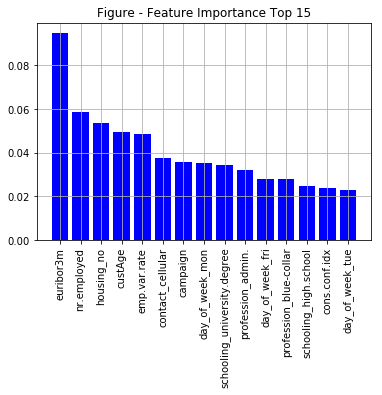

In [20]:
plt.figure()
plt.title("Figure - Feature Importance Top 15")
plt.bar(np.linspace(1, len(values), len(values)), [x[1] for x in values], color="b")
plt.xticks(np.linspace(1, len(values), len(values)), [x[0] for x in values], rotation='vertical')
plt.grid(True)

# 3. Make Prediction for Testing dataset

In [21]:
df_test = pd.read_csv("marketing_test.csv")
df_test=df_test.rename(columns = {df_test.columns[0]:'id'})
df_test.isnull().sum()

id                  0
custAge           210
profession          0
marital             0
schooling         251
default             0
housing             0
loan                0
contact             0
month               0
day_of_week        76
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
pmonths             0
pastEmail           0
dtype: int64

### 3.1 data preprocessing

In [22]:
# (1) open imputation model and feature dictionary saved in section 1.5 and 1.7
with open("custAge.pkl", "rb") as f:
    AgeModel = pickle.load(f)
with open("schooling.pkl", "rb") as f:
    SchoolModel = pickle.load(f)
with open("day_of_week.pkl", "rb") as f:
    DayModel = pickle.load(f)
with open('FeatureDict.json', 'r') as f: 
    List = json.load(f)
    predictors = List['predictors'] # predictors of final model
    categorylist = List['categorylist'] # categorical columns needed to be transformed into dummy
    imputationlist =List['imputationlist'] # columns for predicting missing values in those columns
    Map_schooling = List['Map_schooling'] # Dictionary to map value to index. For predicting missing values
    Map_day = List['Map_day']

In [23]:
# (2) change categorical columns into dummy columns
for item in categorylist: 
    df_test = Category2Dummy(df_test,item) 
df_test = df_test.drop(categorylist, axis = 1) # remove original categorical columns

In [24]:
# (3) missing values imputation

# columns in the training set not in the testing set. set them as 0
imputationlist2 = [x for x in df_test.columns if (x != 'custAge') and (x != 'responded') and (x != 'schooling') and (x != 'day_of_week')]
for column in set(imputationlist) - set(imputationlist2):
    df_test[column] = 0
    
# map category to numeric
df_test['day_of_week'] = df_test['day_of_week'].apply(lambda x: Category2Numeric(x, Map_day))
df_test['schooling'] = df_test['schooling'].apply(lambda x: Category2Numeric(x, Map_schooling))

# predict
df_test = Impute(df_test, AgeModel, imputationlist, 'custAge')
df_test = Impute(df_test, SchoolModel, imputationlist, 'schooling')
df_test = Impute(df_test, DayModel, imputationlist, 'day_of_week')

# map numeric to categorical
df_test['day_of_week'] = df_test['day_of_week'].apply(lambda x: Numeric2Category(x,Map_day))
df_test['schooling'] = df_test['schooling'].apply(lambda x: Numeric2Category(x,Map_schooling))

In [25]:
# (4) convert remaining categorical columns into dummy columns
remain_categorylist = ['schooling', 'day_of_week']
for item in remain_categorylist:
    df_test = Category2Dummy(df_test, item)
df_test = df_test.drop(remain_categorylist, axis = 1)

### 3.2 data prediction

In [26]:
# load the model
with open('Final_Model.pkl','rb') as f:
        finalmodel = pickle.load(f)      

# if columns in training set not in testing, set values as 0
predictors1 = df_test.columns.tolist()[1:] # testing dataset columns
for column in set(predictors) - set(predictors1):
    df_test[column]=0 

In [27]:
# Make prediction and save the model 
df_test['responded'] = finalmodel.predict(df_test[predictors])
df_test[['id','responded']].to_csv("test_prediction.csv")
df_test[['id','responded']]

,id,responded
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,1
9,9,0


In [28]:
df_test.responded.value_counts()

0    779
1     45
Name: responded, dtype: int64